<div style="background-color : white; border-radius: 15px; width: 93%; padding: 2em; color: black; font-family: Gill Sans, sans-serif;">
    <h1 style ="text-align: center; color: black; font-family: Gill Sans, sans-serif;font-weight: 700;"> Classificazione con algoritmi allo stato dell'arte </h1>
    <h2>Indice</h2>
    <ol type="1">
        <li style="padding-top: 0.3em; padding-bottom: 0.3em;"><b>Basi per i modelli</b>
            <ul>
                <li style="padding-top: 0.3em; padding-bottom: 0.3em;">1.1 Pacchetti necessari</li>
                <li>1.2 Caricamento e gestione del dataset</li>
            </ul>
        </li>
        <li style="padding-top: 0.3em; padding-bottom: 0.3em;"><b>Model Selection</b>
            <ul>
                <li style="padding-top: 0.3em; padding-bottom: 0.3em;">2.1 Scelta del modello con k-fold</li>
                <li>2.2 Hyperparameter tuning del modello scelto</li>
            </ul>
        </li>
        <li style="padding-top: 0.3em"><b>Valutazione del modello</b>
            <ul>
                <li style="padding-top: 0.3em; padding-bottom: 0.3em;">3.1 Modello scelto con parametri ottimizzati</li>
                <li style="padding-bottom: 0.3em;">3.2 Learning curves</li>
                <li style="padding-bottom: 0.3em;">3.3 Metrica d'errore</li>
                <li style="padding-bottom: 0.3em;">3.4 Confusion Matrix</li>
                <li style="padding-bottom: 0.3em;">3.5 Curva precision e recall</li>
                <li>3.6 Curva ROC e AUC</li>
            </ul>
        </li>
    </ol>
</div>

<div style="color:black; background-color: white; border-top-left-radius: 15px; border-top-right-radius: 15px; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3 style="font-weight:700;"> 1. Basi per i modelli </h3>
    <h3> 1.1 Pacchetti necessari </h3>
</div>

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

<div style="color:black; background-color: white; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3> 1.2 Caricamento e gestione del dataset </h3>
</div>

In [9]:
# Carico il dataset
path = '../color_extr/data.csv'
data = pd.read_csv(path, usecols = [i for i in range(5)])

# Creo train e test set
X_train, X_test, Y_train, Y_test = train_test_split(data[['presenza_foglie','assenza_foglie','presenza_bachi_sfondo','assenza_bachi_sfondo']], data[['classificazione']], test_size=0.23)

# Normalizzo i dati
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

<div style="background-color: white; border-bottom-left-radius:15px; border-bottom-right-radius:15px; width:93%; padding:2em 2em 0.2em 2em; font-family:Gill Sans, sans-serif;">
</div>

<div style="color:black; background-color: white; border-top-left-radius: 15px; border-top-right-radius: 15px; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif; color:black;">
    <h3 style="font-weight:700;"> 2. Model Selection </h3>
    <h3> 2.1 Scelta del modello con k-fold </h3>
    <p>I modelli da provare sono tre tipi di classificatore: Logistic Regression, Support-Vector Machine (lineari), K-Nearest Neighbors (non lineare).</p>
    <p>Per valutare quale sia il modello ottimale si applica un procedimento k-fold cross validation: il train set viene diviso in k sottoinsiemi, per ognuno di quest'ultimi viene effettuato il train del modello su k-1 sottoinsiemi (uniti) e il test su uno dei k sottoinsiemi. Alla fine del procedimento si determina l'accurancy/errore medio. Si seleziona il modello migliore in base all'accurancy.</p>
</div>

In [10]:
import warnings
warnings.filterwarnings('ignore')

models = [LogisticRegression(), KNeighborsClassifier(), svm.SVC()] 
 
k = 5
kf = KFold(n_splits=k, random_state=None)

for model in models:
	result = cross_val_score(model , X_train, Y_train, cv = kf)
 
	print("- ", str(type(model).__name__).strip(), "avg accuracy: ", str(result.mean()))

-  LogisticRegression avg accuracy:  0.9875
-  KNeighborsClassifier avg accuracy:  0.9932692307692308
-  SVC avg accuracy:  0.989423076923077


<div style="color: black; background-color: white; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3> 2.2 Hyperparameter tuning del modello scelto </h3>
    <p>Tutti e tre i classificatori testati hanno riportato sicuramente degli ottimi risultati. Il migliore tuttavia è stato K-nearest neighbour che diventerà il modello allo stato dell'arte usato come termine di confronto</p>
    <p>Partendo da quest'ultimo, si selezionano gli iperparametri ottimali del modello con un approccio Grid Search: dati una lista di iperparametri candidati, si eseguono delle prove sulle loro combinazioni per ottenere quella ideale</p>
</div>

In [11]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

print(type(models[1]).__name__)

gs = GridSearchCV(models[1], grid_params, verbose = 1, cv=5, n_jobs = -1)

g_res = gs.fit(X_train, Y_train)
g_res.best_params_

KNeighborsClassifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}

<div style="background-color: white; border-bottom-left-radius:15px; border-bottom-right-radius:15px; width:93%; padding:2em 2em 0.2em 2em; font-family:Gill Sans, sans-serif;">
</div>

<div style="color:black; background-color: white; border-top-left-radius: 15px; border-top-right-radius: 15px; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3 style="font-weight:700;"> 3. Valutazione del modello</h3>
    <h3>3.1 Modello scelto con parametri ottimizzati</h3>
</div>

In [13]:
model_knn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', metric = 'manhattan')

knn_fit = model_knn.fit(X_train, Y_train)
predictions_knn = model_knn.predict(X_test)
predictions_knn_scores = model_knn.predict_proba(X_test)[:,1]

train_score = model_knn.score(X_train, Y_train)
test_score = model_knn.score(X_test, Y_test)
print("### KNN:\n\tAccuracy of training: "+str(train_score)+"\n\tAccuracy of test: "+str(test_score))
print("### KNN:\n\tError rate of training: "+str(1 - train_score)+"\n\tError rate of test: "+str(1 - test_score))

### KNN:
	Accuracy of training: 0.9951923076923077
	Accuracy of test: 0.9871382636655949
### KNN:
	Error rate of training: 0.004807692307692291
	Error rate of test: 0.012861736334405127


<div style="color: black; background-color: white; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3>3.2 Learning curves</h3>
</div>

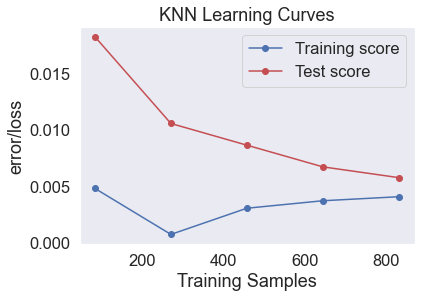

In [20]:
train_size, train_score, test_score = learning_curve(estimator=model_knn, X=X_train, y=Y_train, cv=5, scoring = None )

train_loss_m = 1 - np.mean(train_score, axis=1)
test_loss_m = 1 - np.mean(test_score, axis=1)

plt.plot(train_size, train_loss_m, 'o-', color="b")
plt.plot(train_size, test_loss_m, 'o-', color="r")
plt.legend(('Training score', 'Test score'), loc='best')
plt.xlabel("Training Samples")
plt.ylabel("error/loss")
plt.title("KNN Learning Curves")
plt.grid()

plt.show()

<div style="color:black; background-color: white; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3>3.3 Metrica d'errore</h3>
</div>

In [16]:
# metric_error = #valori classe 0 / #valori classi
metric_error = len(data[data.classificazione == 0]) / len(data)
metric_accurancy = 1 - metric_error

print("Error rate di un classificatore che predice solo 0: ", metric_error)
print("Accuracy di un classificatore che predice solo 0: ", metric_accurancy)

Error rate di un classificatore che predice solo 0:  0.44041450777202074
Accuracy di un classificatore che predice solo 0:  0.5595854922279793


<div style="color:black; background-color: white; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3>3.4 Confusion Matrix</h3>
</div>

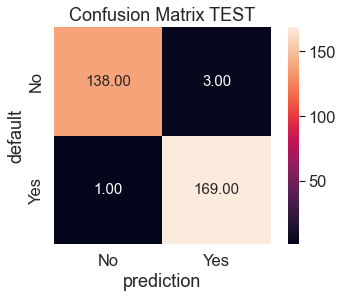

Precision:  0.9825581395348837
Recall:  0.9941176470588236
Specificity:  0.9787234042553191


In [17]:
cm = confusion_matrix(Y_test, predictions_knn)
plt.figure()
sns.set(font_scale=1.5)
hm = sns.heatmap( cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=['No', 'Yes'], xticklabels=['No', 'Yes'])
plt.title('Confusion Matrix TEST')
plt.ylabel('default')
plt.xlabel('prediction')
plt.show()

diagonal = np.diag(cm)
antidiagonal = np.fliplr(cm).diagonal()

false_positive = antidiagonal[0]
false_negative = antidiagonal[1]
true_positive = diagonal[1]
true_negative = diagonal[0]

# Precision
pre = true_positive/(true_positive+false_positive)
# Recall
rec = true_positive/(true_positive+false_negative)
# Specificity
sens = true_negative/(true_negative+false_positive) 

print("Precision: ", pre)
print("Recall: ", rec)
print("Specificity: ", sens)

<div style="color:black; background-color: white; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3>3.5 Curva precision e recall</h3>
</div>

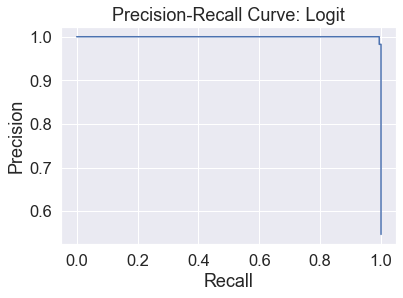

f1-score:  0.9883040935672515


In [18]:
precision, recall, thresholds = precision_recall_curve(Y_test, predictions_knn_scores)
plt.figure()
plt.plot(recall, precision)
plt.title("Precision-Recall Curve: Logit")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print("f1-score: ", f1_score(Y_test, predictions_knn))  

<div style="color:black; background-color: white; width: 93%; padding: 2em 2em 0.2em 2em; font-family: Gill Sans, sans-serif;">
    <h3> 3.6 Curva ROC e AUC </h3>
</div>

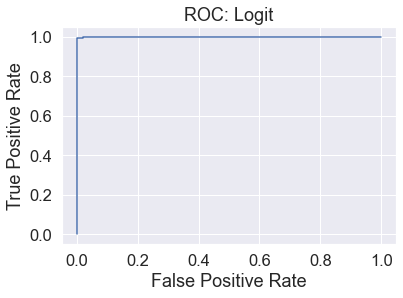

AUC:  0.9864205256570713


In [19]:
fpr, tpr, thresholds = roc_curve(Y_test, predictions_knn_scores)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC: Logit")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print ("AUC: ", roc_auc_score(Y_test, predictions_knn))

<div style="background-color: white; border-bottom-left-radius:15px; border-bottom-right-radius:15px; width:93%; padding:2em 2em 0.2em 2em; font-family:Gill Sans, sans-serif;">
</div>